In [3]:
%load_ext autoreload
%autoreload 2

import os
import random
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

from utils.data import get_data, txt_to_list
from utils.utils import transpose_df, get_df_meta, do_DESeq_inference, list_to_txt

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold

from utils.utils import min_max_norm_TPM
from utils.data import dataloader
from utils.train import training, EarlyStopping, Inference, Accuracy
from utils.models import mlp_model
from utils.plots import plot_confusion

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 1
TPM_threshold = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# # reproducibiliy

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch.use_deterministic_algorithms(True)

# 1. Load Data

In [5]:
DATA_PATH = 'Data'
IDX_COLUMN = 'Gene_ID'

# these two different orderings are used throughout the code => select one?
stress_types = ['Cold', 'Salt', 'Heat', 'Drought']
stress_types_ord = ['Salt', 'Cold', 'Heat', 'Drought']

print('Number of data')
print('=' * 20)

df_TPM = {}
for stress in stress_types:
    tpm_filepath = os.path.join(DATA_PATH, f'TPM_{stress}_Stress.csv')
    df_TPM[stress] = get_data(tpm_filepath, index_column=IDX_COLUMN)
    print(f'{stress}: {df_TPM[stress].shape[1]}')


Number of data
Cold: 592
Salt: 384
Heat: 666
Drought: 646


In [6]:
print('Number of control samples')
print('=' * 20)

control_list = {}
for stress in stress_types:
    control_list[stress] = txt_to_list(os.path.join(DATA_PATH, f'id_control_{stress.lower()}.txt'))
    print(f'{stress}: {len(control_list[stress])}')

print('\nNumber of stress-treated samples')
print('=' * 20)

samples_list = {}
for stress in stress_types:
    samples_list[stress] = txt_to_list(os.path.join(DATA_PATH, f'id_samples_{stress.lower()}.txt'))
    print(f'{stress}: {len(samples_list[stress])}')

Number of control samples
Cold: 82
Salt: 100
Heat: 183
Drought: 147

Number of stress-treated samples
Cold: 148
Salt: 133
Heat: 266
Drought: 184


In [7]:
def stable_key(x):
    return hashlib.sha256(str(x).encode()).hexdigest()

n_control_training = 30
n_control_testing = 3
n_samples_training = 120
n_samples_testing = 13

control_list_training = {}
control_list_testing = {}
samples_list_training = {}
samples_list_testing = {}


# split into 4 for-loops to replicate the original randomness
for stress in stress_types:
    control_list_training[stress] = random.sample(control_list[stress], n_control_training)

for stress in stress_types:   
    n = 4 if stress=='Drought' else n_control_testing # why 4 only for Drought?
    control_list_testing[stress] = random.sample(sorted(set(control_list[stress]) - set(control_list_training[stress]), key=stable_key), n)

for stress in stress_types:
    samples_list_training[stress] = random.sample(samples_list[stress], n_samples_training)

for stress in stress_types:
    samples_list_testing[stress] = random.sample(sorted(set(samples_list[stress]) - set(samples_list_training[stress]), key=stable_key), n_samples_testing)


In [8]:
# dataframes for training
sample_TPM = {}
control_TPM = {}

for stress in stress_types:
    sample_TPM[stress] = df_TPM[stress][samples_list_training[stress]]
    control_TPM[stress] = df_TPM[stress][control_list_training[stress]]

con_IDs = {}
sam_IDs = {}
all_con_IDs = []
for stress in stress_types_ord:
    con_IDs[stress] = control_TPM[stress].columns.values
    sam_IDs[stress] = sample_TPM[stress].columns.values
    all_con_IDs += list(con_IDs[stress])

all_control_TPM = pd.concat([control_TPM[stress] for stress in stress_types_ord], axis=1)
all_control_TPM

,SRR20354682,SRR9693074,SRR17659932,SRR10027508,DRR244355,SRR19139707,ERR3385333,SRR17659933,SRR10027519,SRR976162,...,DRR400619,SRR12687374,ERR1588921,SRR3993554,ERR1588870,ERR1588945,ERR1588941,ERR1588810,ERR1588924,DRR118343
Gene_ID,,,,,,,,,,,,,,,,,,,,,
AT1G01010.1,6,7,10,10,7,4,7,6,14,5,...,2,4,3,3,3,4,7,1,3,2
AT1G01020.1,13,36,18,7,2,14,22,16,7,16,...,15,23,31,6,37,37,34,44,24,13
AT1G01030.1,1,5,1,5,3,3,2,2,5,3,...,2,2,9,6,9,7,16,5,12,3
AT1G01040.2,8,10,10,9,5,7,10,9,9,7,...,8,12,15,4,11,7,8,7,13,8
AT1G01050.1,83,62,106,96,44,80,71,110,86,155,...,68,93,55,42,57,60,73,63,56,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATMG01350.1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ATMG01360.1,0,4,1,1,0,0,2,1,1,0,...,0,0,4,0,2,4,1,1,0,0
ATMG01370.1,0,11,4,0,0,1,7,5,0,4,...,3,5,1,4,2,0,0,1,0,0


In [9]:
list_dfs = [all_control_TPM] + [sample_TPM[stress] for stress in stress_types_ord]
all_TPM = pd.concat(list_dfs, axis=1)
all_TPM_ov1 = all_TPM
all_TPM_ov1

,SRR20354682,SRR9693074,SRR17659932,SRR10027508,DRR244355,SRR19139707,ERR3385333,SRR17659933,SRR10027519,SRR976162,...,SRR10690487,SRR10690549,SRR8368642,ERR5732377,SRR17036060,SRR10690555,DRR400612,SRR649739,SRR10690516,SRR19184802
Gene_ID,,,,,,,,,,,,,,,,,,,,,
AT1G01010.1,6,7,10,10,7,4,7,6,14,5,...,6,14,4,4,5,6,1,2,15,1
AT1G01020.1,13,36,18,7,2,14,22,16,7,16,...,13,16,10,9,10,12,12,6,10,5
AT1G01030.1,1,5,1,5,3,3,2,2,5,3,...,1,0,0,24,0,0,1,5,0,0
AT1G01040.2,8,10,10,9,5,7,10,9,9,7,...,16,25,14,5,7,14,9,6,16,1
AT1G01050.1,83,62,106,96,44,80,71,110,86,155,...,94,94,84,68,61,77,70,121,103,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATMG01350.1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,16
ATMG01360.1,0,4,1,1,0,0,2,1,1,0,...,1,2,0,3,0,0,0,1,3,839
ATMG01370.1,0,11,4,0,0,1,7,5,0,4,...,0,3,5,9,0,4,2,4,4,28


# 2. DESeq2 Analysis

In [10]:
merged_TPM = {}
merged_TPM_ov1 = {}
trans_merged_TPM_ov1 = {}

for stress in stress_types:
    merged_TPM[stress] = pd.concat([all_control_TPM, sample_TPM[stress]], axis=1)
    merged_TPM_ov1[stress] = merged_TPM[stress][merged_TPM[stress].max(axis=1) >= TPM_threshold]
    trans_merged_TPM_ov1[stress] = transpose_df(merged_TPM_ov1[stress])


In [11]:
df_meta = {}
for stress in stress_types:
    df_meta[stress] = get_df_meta(all_con_IDs, sam_IDs[stress])

df_meta['Drought']

,condition
,
SRR20354682,control
SRR9693074,control
SRR17659932,control
SRR10027508,control
DRR244355,control
...,...
SRR10690555,treated
DRR400612,treated
SRR649739,treated


Fitting size factors...
... done in 0.16 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.57 seconds.

Fitting dispersion trend curve...
... done in 0.98 seconds.

Fitting MAP dispersions...
... done in 1.95 seconds.

Fitting LFCs...
... done in 1.67 seconds.

Calculating cook's distance...
... done in 0.48 seconds.

Replacing 733 outlier genes.

Fitting dispersions...
... done in 0.24 seconds.

Fitting MAP dispersions...
... done in 0.22 seconds.

Fitting LFCs...
... done in 0.28 seconds.

Running Wald tests...
... done in 1.38 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
AT1G01010.1   7.124365        0.929203  0.130057  7.144573  9.027578e-13   
AT1G01020.1  14.903771       -0.271733  0.095146 -2.855972  4.290524e-03   
AT1G01040.2   7.345359       -0.185780  0.080372 -2.311495  2.080553e-02   
AT1G01050.1  85.124686        0.115038  0.066069  1.741174  8.165302e-02   
AT1G01060.1  58.415164       -0.026888  0.343836 -0.078200  9.376689e-01   
...                ...             ...       ...       ...           ...   
ATMG01320.1   2.829067       -2.890659  0.651428 -4.437420  9.104358e-06   
ATMG01330.1   2.649720       -0.624995  0.270145 -2.313558  2.069197e-02   
ATMG01350.1   1.164452       -2.423724  0.925040 -2.620129  8.789660e-03   
ATMG01360.1   5.970126       -2.658919  0.407798 -6.520186  7.022038e-11   
ATMG01370.1   4.672524       -0.891906  0.249647 -3.572674  3.533542e-04   

                    

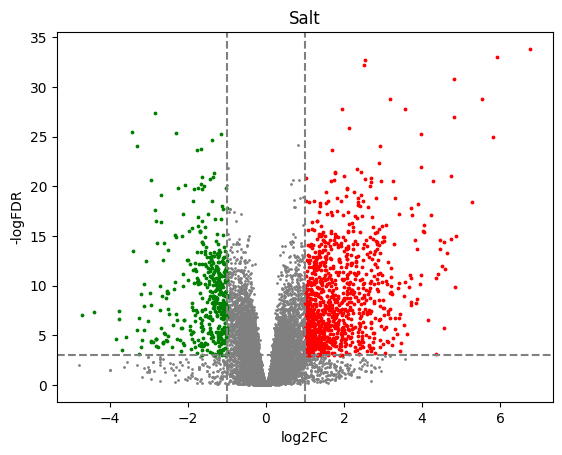

Number of DEG Up: 1017 | Number of DEG Down: 445 | Total number of DEG: 1462


Fitting size factors...
... done in 0.15 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.77 seconds.

Fitting dispersion trend curve...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 1.96 seconds.

Fitting LFCs...
... done in 1.83 seconds.

Calculating cook's distance...
... done in 0.47 seconds.

Replacing 617 outlier genes.

Fitting dispersions...
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 0.34 seconds.

Fitting LFCs...
... done in 0.39 seconds.

Running Wald tests...
... done in 1.27 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
AT1G01010.1   4.585604        0.150612  0.118928  1.266411  2.053661e-01   
AT1G01020.1  12.420627       -0.526419  0.088842 -5.925358  3.116177e-09   
AT1G01040.2   7.650262        0.237200  0.081328  2.916583  3.538886e-03   
AT1G01050.1  84.255567        0.364587  0.063120  5.776056  7.647189e-09   
AT1G01060.1  79.793046        0.998914  0.275880  3.620834  2.936553e-04   
...                ...             ...       ...       ...           ...   
ATMG01320.1   4.085091       -0.354338  0.900304 -0.393576  6.938942e-01   
ATMG01330.1   2.838483       -0.129241  0.243800 -0.530110  5.960354e-01   
ATMG01350.1   2.278885        0.721836  1.174717  0.614477  5.389003e-01   
ATMG01360.1   6.258092       -1.594752  0.433217 -3.681186  2.321515e-04   
ATMG01370.1   3.662668       -1.633446  0.257686 -6.338904  2.314048e-10   

                    

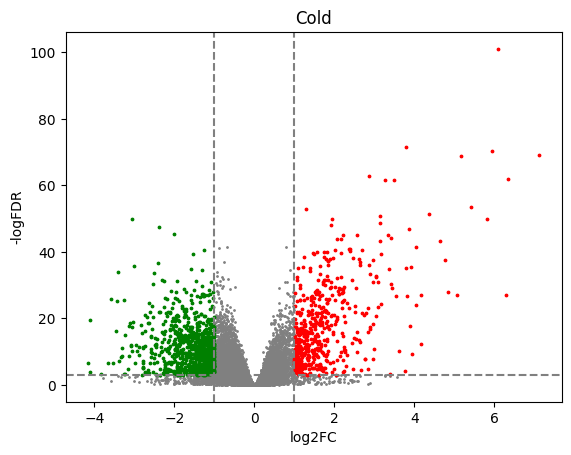

Number of DEG Up: 517 | Number of DEG Down: 954 | Total number of DEG: 1471


Fitting size factors...
... done in 0.15 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.63 seconds.

Fitting dispersion trend curve...
... done in 0.58 seconds.

Fitting MAP dispersions...
... done in 1.88 seconds.

Fitting LFCs...
... done in 2.09 seconds.

Calculating cook's distance...
... done in 0.47 seconds.

Replacing 788 outlier genes.

Fitting dispersions...
... done in 0.26 seconds.

Fitting MAP dispersions...
... done in 0.24 seconds.

Fitting LFCs...
... done in 0.29 seconds.

Running Wald tests...
... done in 1.41 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
              baseMean  log2FoldChange     lfcSE       stat        pvalue  \
AT1G01010.1   4.160785        0.046457  0.115812   0.401141  6.883165e-01   
AT1G01020.1  12.940841       -0.240724  0.101776  -2.365231  1.801883e-02   
AT1G01040.2   6.448285       -0.091210  0.106425  -0.857038  3.914240e-01   
AT1G01050.1  70.782484        0.007898  0.057858   0.136510  8.914181e-01   
AT1G01060.1  38.066360       -1.001475  0.354669  -2.823686  4.747482e-03   
...                ...             ...       ...        ...           ...   
ATMG01330.1   5.012664        1.456525  0.267760   5.439665  5.338073e-08   
ATMG01350.1   2.652681        1.241991  0.539998   2.299992  2.144866e-02   
ATMG01360.1  33.276697        2.646158  0.394784   6.702801  2.044614e-11   
ATMG01370.1  21.022309        2.830087  0.256474  11.034617  2.601580e-28   
ATMG01400.1   0.913859        2.852796  0.802720   3.553911  3.795475e-04   

        

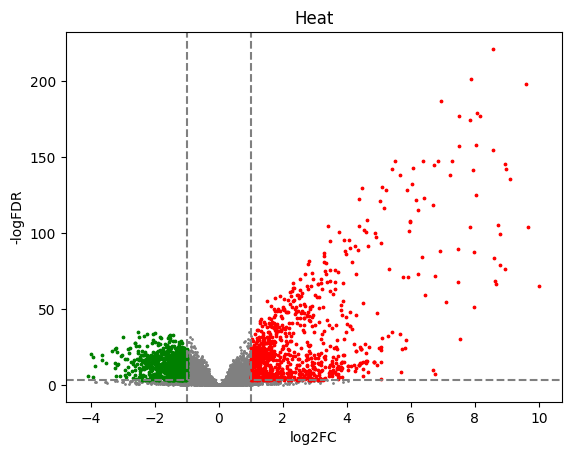

Number of DEG Up: 917 | Number of DEG Down: 1006 | Total number of DEG: 1923


Fitting size factors...
... done in 0.15 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.77 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 1.95 seconds.

Fitting LFCs...
... done in 1.65 seconds.

Calculating cook's distance...
... done in 0.47 seconds.

Replacing 668 outlier genes.

Fitting dispersions...
... done in 0.39 seconds.

Fitting MAP dispersions...
... done in 0.39 seconds.

Fitting LFCs...
... done in 0.49 seconds.

Running Wald tests...
... done in 1.48 seconds.



Log2 fold change & Wald test p-value: condition treated vs control
              baseMean  log2FoldChange     lfcSE      stat        pvalue  \
AT1G01010.1   4.750711        0.090409  0.116066  0.778944  4.360126e-01   
AT1G01020.1  13.264161       -0.538142  0.085797 -6.272246  3.558775e-10   
AT1G01030.1   2.096362       -1.627036  0.260564 -6.244287  4.257379e-10   
AT1G01040.2   8.310240        0.334276  0.091949  3.635435  2.775123e-04   
AT1G01050.1  77.209533       -0.054889  0.049764 -1.102982  2.700352e-01   
...                ...             ...       ...       ...           ...   
ATMG01320.1  49.326376        4.264675  0.926615  4.602425  4.176002e-06   
ATMG01330.1   4.604600        1.000659  0.231420  4.323992  1.532309e-05   
ATMG01350.1   3.524014        1.510819  0.930098  1.624365  1.042979e-01   
ATMG01360.1  96.391366        4.180938  0.545249  7.667939  1.747818e-14   
ATMG01370.1   9.016766        1.067996  0.268437  3.978571  6.933064e-05   

                    

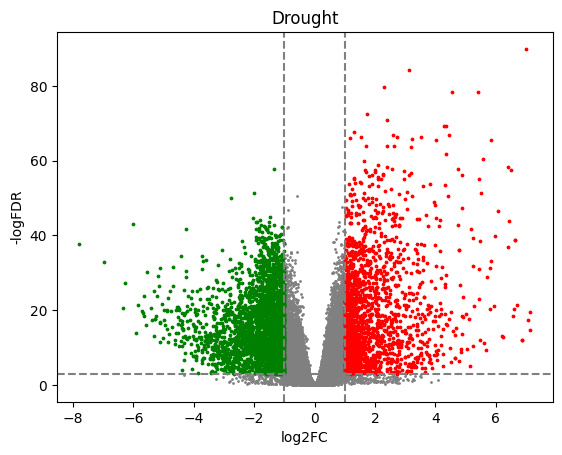

Number of DEG Up: 1703 | Number of DEG Down: 2587 | Total number of DEG: 4290


In [12]:
DEG = {}
DEG_up = {}
DEG_down = {}

for stress in stress_types_ord:
    DEG[stress], DEG_up[stress], DEG_down[stress] = do_DESeq_inference(trans_merged_TPM_ov1[stress], 
                                                                       df_meta[stress],
                                                                       plot=True,
                                                                       stress=stress,
                                                                       log2fc=1,
                                                                       padj=0.001)

In [13]:
all_gene_ids = all_TPM_ov1.index.values.tolist()

In [14]:

def stable_key(x):
    return hashlib.sha256(str(x).encode()).hexdigest()

DEG_down_unique = {}
DEG_up_unique = {}

for stress in stress_types:
    others = set(stress_types) - {stress} # stresses other than "stress" in the loop
    DEG_down_unique[stress] = set(DEG_down[stress])
    DEG_up_unique[stress] = set(DEG_up[stress])

    for other_stress in others:
        DEG_down_unique[stress] = DEG_down_unique[stress] - set(DEG_down[other_stress])
        DEG_up_unique[stress] = DEG_up_unique[stress] - set(DEG_up[other_stress])

    DEG_down_unique[stress] = DEG_down_unique[stress].intersection(set(all_gene_ids))
    DEG_up_unique[stress] = DEG_up_unique[stress].intersection(set(all_gene_ids))

    DEG_down_unique[stress] = sorted(DEG_down_unique[stress], key=stable_key)
    DEG_up_unique[stress] = sorted(DEG_up_unique[stress], key=stable_key)

print('Number of unique elements in each stress of DEG_down')
for stress in stress_types:
    print(f'{stress}: {len(DEG_down_unique[stress])}')

print('\nNumber of unique elements in each stress of DEG_up')
for stress in stress_types:
    print(f'{stress}: {len(DEG_up_unique[stress])}')


Number of unique elements in each stress of DEG_down
Cold: 319
Salt: 81
Heat: 320
Drought: 1626

Number of unique elements in each stress of DEG_up
Cold: 287
Salt: 581
Heat: 632
Drought: 1076


In [15]:
n_samples = 40
rng = random.Random(RANDOM_SEED)

DEG_down_sub = {}
DEG_up_sub = {}
for stress in stress_types:
    DEG_down_sub[stress] = rng.sample(DEG_down_unique[stress], k=n_samples)
    DEG_up_sub[stress] = rng.sample(DEG_up_unique[stress], k=n_samples)

all_unique_degs = []
for stress in stress_types:
    all_unique_degs.extend(DEG_down_sub[stress])

for stress in stress_types:
    all_unique_degs.extend(DEG_up_sub[stress])


In [16]:
for stress in stress_types:
    list_to_txt(DEG_down[stress], f'Export/{stress.lower()}_DEG_down.txt')
    list_to_txt(DEG_up[stress], f'Export/{stress.lower()}_DEG_up.txt')
    list_to_txt(DEG_down_unique[stress], f'Export/{stress.lower()}_DEG_down_unique.txt')
    list_to_txt(DEG_up_unique[stress], f'Export/{stress.lower()}_DEG_up_unique.txt')
    list_to_txt(DEG_down_sub[stress], f'Export/{stress.lower()}_DEG_down_sub.txt')
    list_to_txt(DEG_up_sub[stress], f'Export/{stress.lower()}_DEG_up_sub.txt')

In [17]:
# Now, this is reproducible.
all_TPM_ov1_deg_filtered = all_TPM_ov1.loc[all_unique_degs]
all_TPM_ov1_deg_filtered

,SRR20354682,SRR9693074,SRR17659932,SRR10027508,DRR244355,SRR19139707,ERR3385333,SRR17659933,SRR10027519,SRR976162,...,SRR10690487,SRR10690549,SRR8368642,ERR5732377,SRR17036060,SRR10690555,DRR400612,SRR649739,SRR10690516,SRR19184802
Gene_ID,,,,,,,,,,,,,,,,,,,,,
AT1G24600.1,7,5,12,6,3,5,8,10,4,7,...,47,1,9,10,55,2,3,1,14,3
AT5G49500.1,4,5,2,4,3,2,3,4,4,1,...,5,5,7,0,2,3,2,1,3,0
AT5G25240.1,67,7,8,8,5,14,8,17,5,4,...,22,0,8,20,42,1,30,5,4,0
AT2G41100.1,470,609,276,118,203,241,340,172,324,272,...,49,569,28,334,235,261,220,9,461,48
AT1G07985.1,3,5,5,3,2,2,0,6,8,1,...,146,0,80,3,151,0,3,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT2G04450.1,1,20,5,8,3,2,1,3,12,10,...,2,124,0,2,8,51,11,5,77,1
AT1G65800.1,23,13,55,7,10,5,7,27,10,9,...,42,232,37,8,27,158,29,16,195,7
AT1G66390.1,0,1,0,0,1,0,0,0,0,3,...,115,1,54,0,2,0,1,0,1,1


# 3. Training Classification Model

In [18]:
# min-max scaling
all_TPM_ov1_deg_filtered_trans_log2, min_max_dic = min_max_norm_TPM(all_TPM_ov1_deg_filtered)
min_max_dic["marker_list"] = all_unique_degs # save marker gene list in the model


Min-Max scaling of input data is in progress..



### Label data = 0: control  1: salt  2: cold  3: heat  4: drought

In [19]:
# assign labels
print('Lengths of data')
print(15 * '=')

label = [0] * len(all_con_IDs)
print(f'Control: {len(all_con_IDs)}')

for i, stress in enumerate(stress_types_ord):
    label.extend([i + 1] * len(samples_list_training[stress]))
    print(f'{stress}: {len(samples_list_training[stress])}')


Lengths of data
Control: 120
Salt: 120
Cold: 120
Heat: 120
Drought: 120


In [20]:
# load data
x_data, y_data = dataloader(all_TPM_ov1_deg_filtered_trans_log2.values.T, label)
x_data.shape, x_data.dtype, y_data.shape, y_data.dtype

(torch.Size([600, 320]), torch.float32, torch.Size([600]), torch.int64)

In [21]:
all_skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

Training on cuda...
Number of data

Training Data: 480  Validation Data: 60 Test Data: 60
mlp_model(
  (classifier): Sequential(
    (0): Linear(in_features=320, out_features=5, bias=True)
  )
)



Cross Validation Fold: 1:  25%|█████████████████████████████████                                                                                                     | 986/4000 [00:24<01:15, 40.15it/s]



Early Stop Epoch: 486
Validation Confusion Matrix:



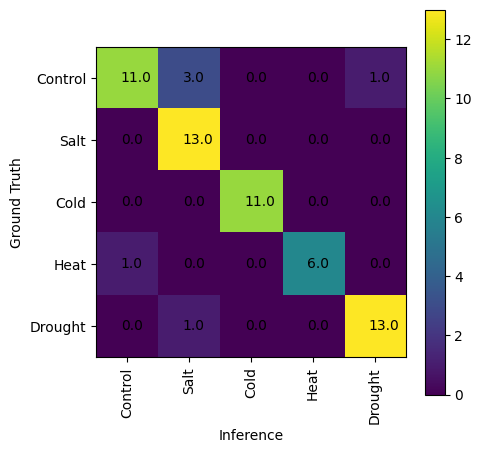

Validation Classification Report:

              precision    recall  f1-score   support

     Control       0.92      0.73      0.81        15
        Salt       0.76      1.00      0.87        13
        Cold       1.00      1.00      1.00        11
        Heat       1.00      0.86      0.92         7
     Drought       0.93      0.93      0.93        14

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.91        60
weighted avg       0.91      0.90      0.90        60

Test Confusion Matrix:



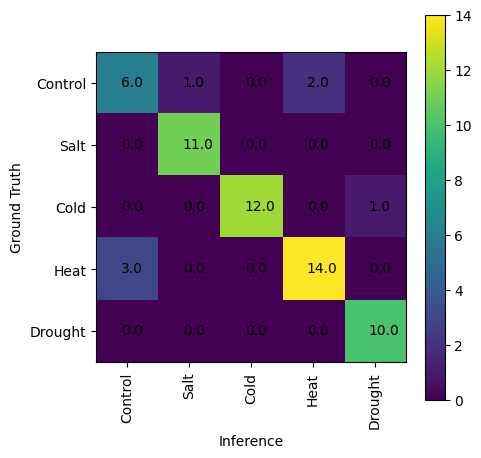

Test Classification Report:

              precision    recall  f1-score   support

     Control       0.67      0.67      0.67         9
        Salt       0.92      1.00      0.96        11
        Cold       1.00      0.92      0.96        13
        Heat       0.88      0.82      0.85        17
     Drought       0.91      1.00      0.95        10

    accuracy                           0.88        60
   macro avg       0.87      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



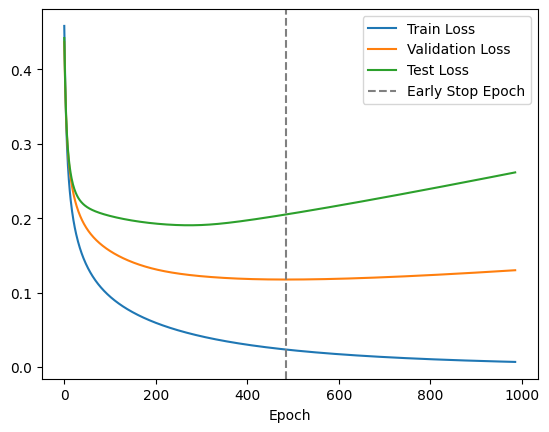

Number of data

Training Data: 480  Validation Data: 60 Test Data: 60
mlp_model(
  (classifier): Sequential(
    (0): Linear(in_features=320, out_features=5, bias=True)
  )
)



Cross Validation Fold: 2:  30%|████████████████████████████████████████▏                                                                                            | 1209/4000 [00:28<01:04, 43.00it/s]



Early Stop Epoch: 709
Validation Confusion Matrix:



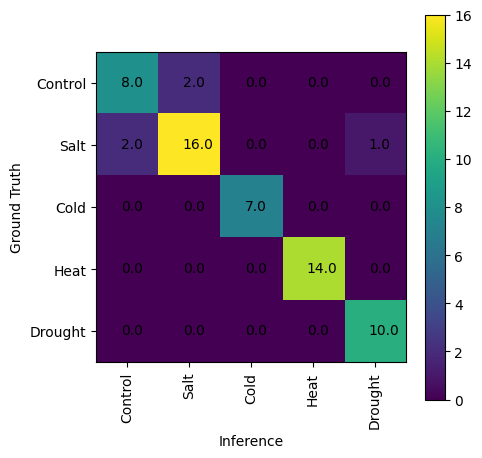

Validation Classification Report:

              precision    recall  f1-score   support

     Control       0.80      0.80      0.80        10
        Salt       0.89      0.84      0.86        19
        Cold       1.00      1.00      1.00         7
        Heat       1.00      1.00      1.00        14
     Drought       0.91      1.00      0.95        10

    accuracy                           0.92        60
   macro avg       0.92      0.93      0.92        60
weighted avg       0.92      0.92      0.92        60

Test Confusion Matrix:



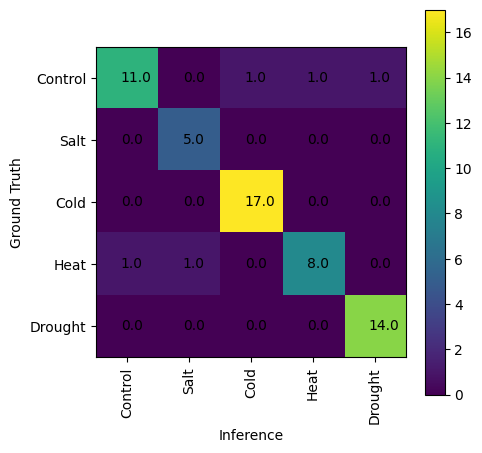

Test Classification Report:

              precision    recall  f1-score   support

     Control       0.92      0.79      0.85        14
        Salt       0.83      1.00      0.91         5
        Cold       0.94      1.00      0.97        17
        Heat       0.89      0.80      0.84        10
     Drought       0.93      1.00      0.97        14

    accuracy                           0.92        60
   macro avg       0.90      0.92      0.91        60
weighted avg       0.92      0.92      0.91        60



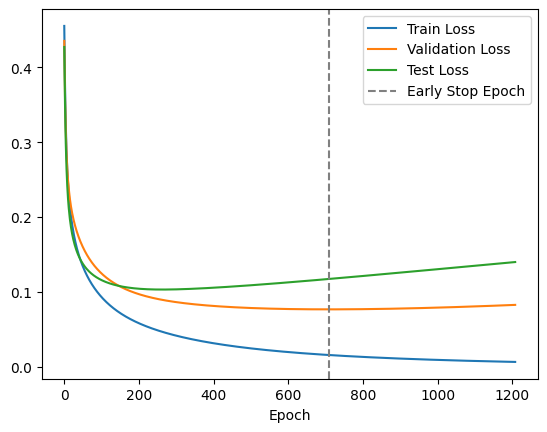

Number of data

Training Data: 480  Validation Data: 60 Test Data: 60
mlp_model(
  (classifier): Sequential(
    (0): Linear(in_features=320, out_features=5, bias=True)
  )
)



Cross Validation Fold: 3:  26%|██████████████████████████████████▊                                                                                                  | 1048/4000 [00:24<01:08, 42.98it/s]



Early Stop Epoch: 548
Validation Confusion Matrix:



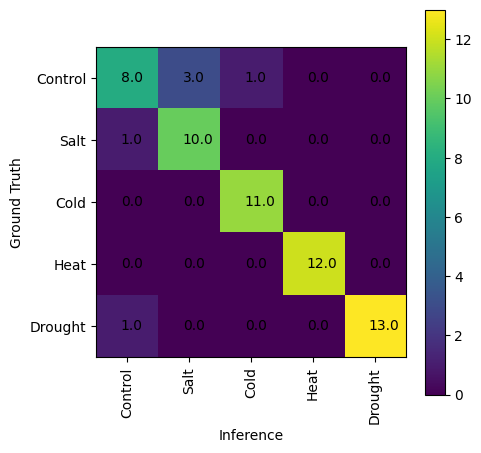

Validation Classification Report:

              precision    recall  f1-score   support

     Control       0.80      0.67      0.73        12
        Salt       0.77      0.91      0.83        11
        Cold       0.92      1.00      0.96        11
        Heat       1.00      1.00      1.00        12
     Drought       1.00      0.93      0.96        14

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60

Test Confusion Matrix:



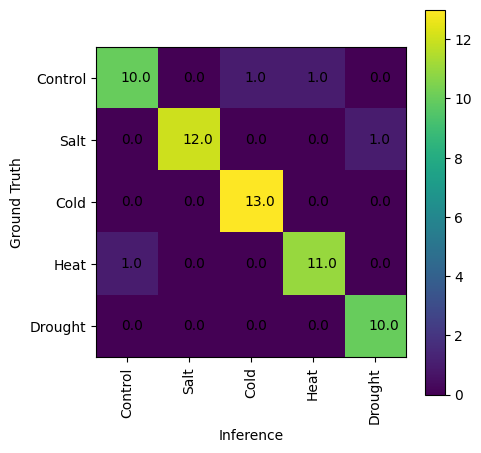

Test Classification Report:

              precision    recall  f1-score   support

     Control       0.91      0.83      0.87        12
        Salt       1.00      0.92      0.96        13
        Cold       0.93      1.00      0.96        13
        Heat       0.92      0.92      0.92        12
     Drought       0.91      1.00      0.95        10

    accuracy                           0.93        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.93      0.93      0.93        60



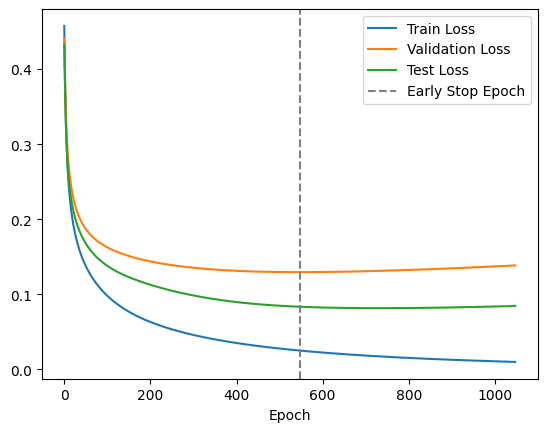

Number of data

Training Data: 480  Validation Data: 60 Test Data: 60
mlp_model(
  (classifier): Sequential(
    (0): Linear(in_features=320, out_features=5, bias=True)
  )
)



Cross Validation Fold: 4:  23%|███████████████████████████████                                                                                                       | 926/4000 [00:21<01:11, 43.24it/s]



Early Stop Epoch: 426
Validation Confusion Matrix:



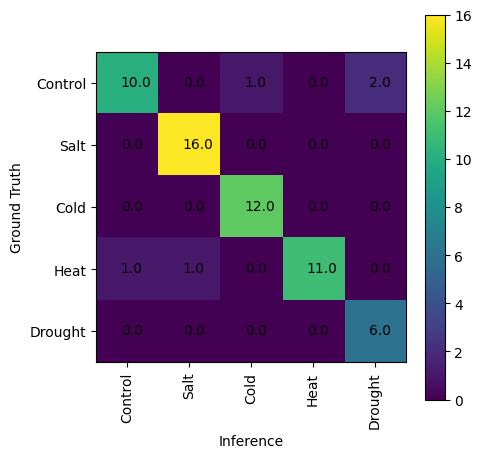

Validation Classification Report:

              precision    recall  f1-score   support

     Control       0.91      0.77      0.83        13
        Salt       0.94      1.00      0.97        16
        Cold       0.92      1.00      0.96        12
        Heat       1.00      0.85      0.92        13
     Drought       0.75      1.00      0.86         6

    accuracy                           0.92        60
   macro avg       0.90      0.92      0.91        60
weighted avg       0.92      0.92      0.92        60

Test Confusion Matrix:



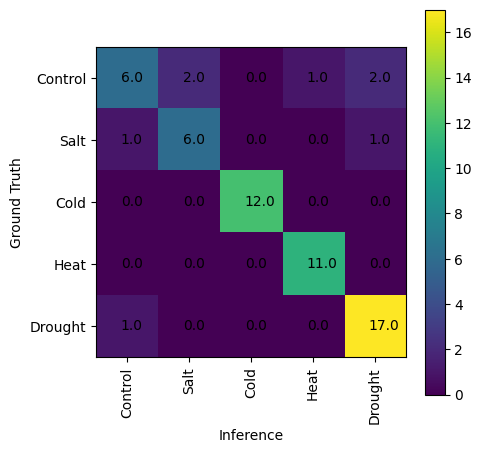

Test Classification Report:

              precision    recall  f1-score   support

     Control       0.75      0.55      0.63        11
        Salt       0.75      0.75      0.75         8
        Cold       1.00      1.00      1.00        12
        Heat       0.92      1.00      0.96        11
     Drought       0.85      0.94      0.89        18

    accuracy                           0.87        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.86      0.87      0.86        60



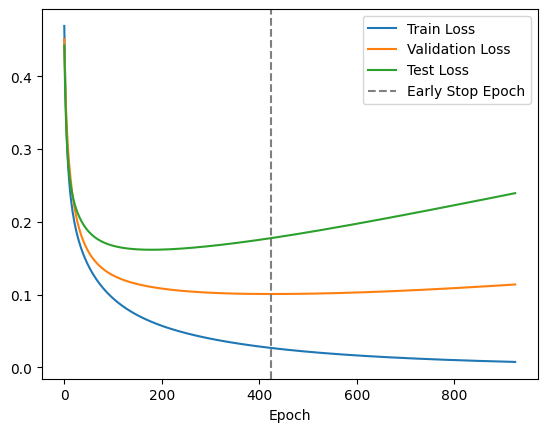

Number of data

Training Data: 480  Validation Data: 60 Test Data: 60
mlp_model(
  (classifier): Sequential(
    (0): Linear(in_features=320, out_features=5, bias=True)
  )
)



Cross Validation Fold: 5:  22%|█████████████████████████████                                                                                                         | 867/4000 [00:20<01:12, 42.97it/s]



Early Stop Epoch: 367
Validation Confusion Matrix:



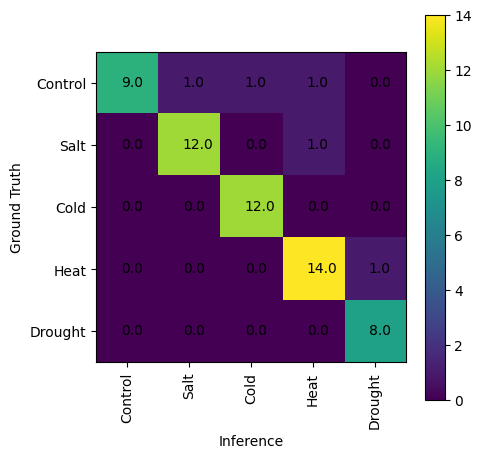

Validation Classification Report:

              precision    recall  f1-score   support

     Control       1.00      0.75      0.86        12
        Salt       0.92      0.92      0.92        13
        Cold       0.92      1.00      0.96        12
        Heat       0.88      0.93      0.90        15
     Drought       0.89      1.00      0.94         8

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.91        60

Test Confusion Matrix:



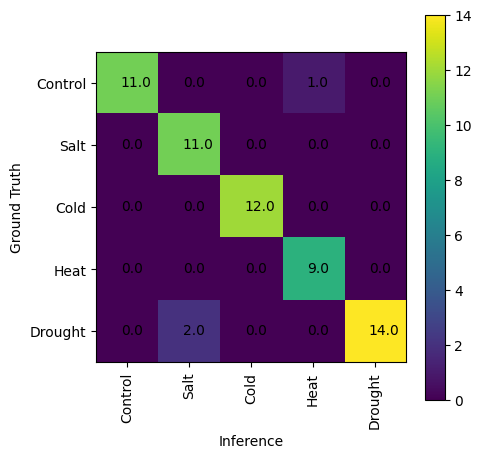

Test Classification Report:

              precision    recall  f1-score   support

     Control       1.00      0.92      0.96        12
        Salt       0.85      1.00      0.92        11
        Cold       1.00      1.00      1.00        12
        Heat       0.90      1.00      0.95         9
     Drought       1.00      0.88      0.93        16

    accuracy                           0.95        60
   macro avg       0.95      0.96      0.95        60
weighted avg       0.96      0.95      0.95        60



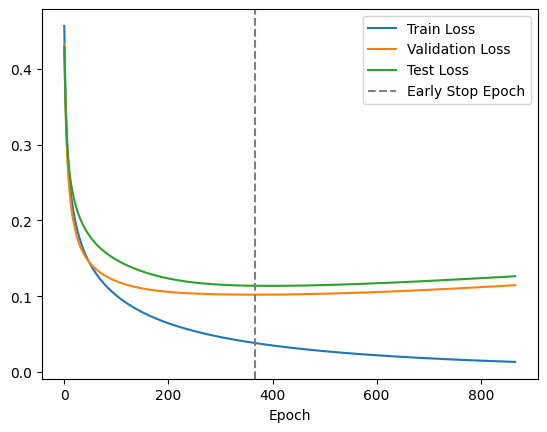

In [22]:
parameter_dic = training(x_data, y_data, min_max_dic, all_skfold, 
                         batch_num=84, learning_rate=0.005, 
                         model_save_path="Trained_models",  cuda_vis_dev=0) # zero hidden layer

# <font color="yellow">Model performance test with independant data</font>

In [23]:
stress_types

['Cold', 'Salt', 'Heat', 'Drought']

In [24]:
stress_types_ord

['Salt', 'Cold', 'Heat', 'Drought']

In [25]:
# Here, stress_types and stress_types_ord are intermixed!
# Data preparation
testing_TPM = {}
control_testing_TPM = {}

for stress in stress_types_ord:
    testing_TPM[stress] = df_TPM[stress][samples_list_testing[stress]]
    control_testing_TPM[stress] = df_TPM[stress][control_list_testing[stress]]

all_control_testing_df = pd.concat([control_testing_TPM[stress] for stress in stress_types], axis=1)

# Dataframe of testing TPM
temp_df = pd.concat([testing_TPM[stress] for stress in stress_types_ord], axis=1)
all_testing_tpm = pd.concat([all_control_testing_df, temp_df], axis=1)
testing_tpm = all_testing_tpm.loc[all_unique_degs]

# labeling of testing data
testing_label = [0] * all_control_testing_df.shape[1] 
for i, stess in enumerate(stress_types_ord):
    testing_label.extend([i + 1] * len(samples_list_testing[stress]))

In [26]:
all_control_testing_df

,SRR25112184,ERR2592724,SRR18163839,SRR21423917,SRR975543,SRR21423912,SRR5054273,SRR15045008,SRR20696323,ERR1589001,ERR1588854,ERR1588900,ERR1588927
Gene_ID,,,,,,,,,,,,,
AT1G01010.1,5,1,5,3,3,3,5,6,6,3,5,4,3
AT1G01020.1,5,5,10,13,25,13,5,6,14,15,37,38,34
AT1G01030.1,2,3,2,2,3,1,3,5,3,3,11,8,9
AT1G01040.2,4,6,5,3,6,3,5,6,7,4,8,7,7
AT1G01050.1,84,98,58,57,180,77,82,70,81,77,64,64,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATMG01350.1,0,1,0,0,0,0,3,0,0,0,0,0,0
ATMG01360.1,0,1,1,2,2,1,4,0,0,2,1,3,2
ATMG01370.1,3,2,1,7,7,3,6,0,1,0,0,1,0


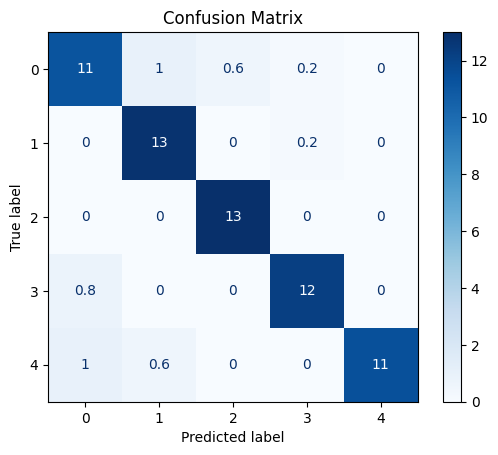

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=All_confusion/5, display_labels=label_dic)

# Plot the confusion matrix with a colormap of your choice (e.g., 'Blues' here)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()




========== Infer with model_1.pth parameters ==========

Min-Max scaling of input data is in progress..

Confusion Matrix:



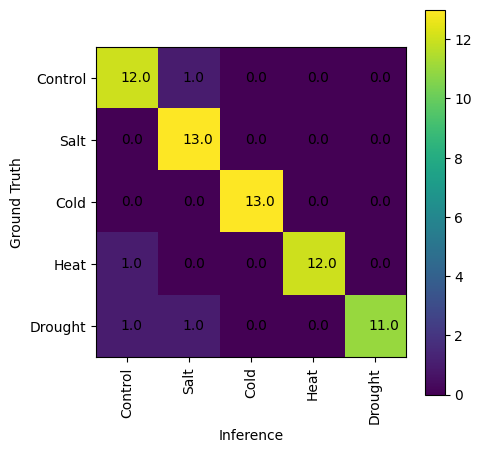


Classification Report:

              precision    recall  f1-score   support

     Control       0.86      0.92      0.89        13
        Salt       0.87      1.00      0.93        13
        Cold       1.00      1.00      1.00        13
        Heat       1.00      0.92      0.96        13
     Drought       1.00      0.85      0.92        13

    accuracy                           0.94        65
   macro avg       0.94      0.94      0.94        65
weighted avg       0.94      0.94      0.94        65



========== Infer with model_2.pth parameters ==========

Min-Max scaling of input data is in progress..

Confusion Matrix:



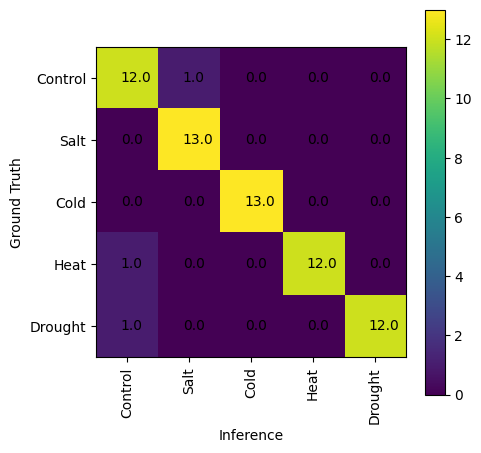


Classification Report:

              precision    recall  f1-score   support

     Control       0.86      0.92      0.89        13
        Salt       0.93      1.00      0.96        13
        Cold       1.00      1.00      1.00        13
        Heat       1.00      0.92      0.96        13
     Drought       1.00      0.92      0.96        13

    accuracy                           0.95        65
   macro avg       0.96      0.95      0.95        65
weighted avg       0.96      0.95      0.95        65



========== Infer with model_3.pth parameters ==========

Min-Max scaling of input data is in progress..

Confusion Matrix:



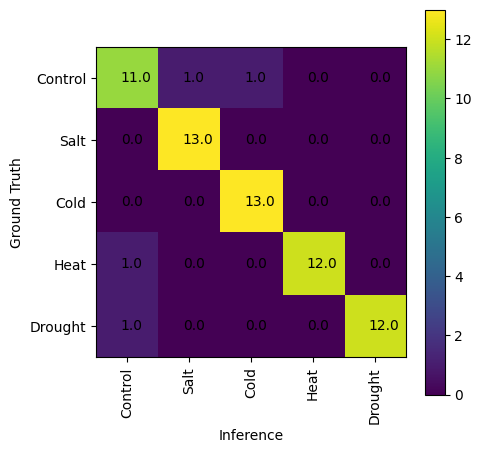


Classification Report:

              precision    recall  f1-score   support

     Control       0.85      0.85      0.85        13
        Salt       0.93      1.00      0.96        13
        Cold       0.93      1.00      0.96        13
        Heat       1.00      0.92      0.96        13
     Drought       1.00      0.92      0.96        13

    accuracy                           0.94        65
   macro avg       0.94      0.94      0.94        65
weighted avg       0.94      0.94      0.94        65



========== Infer with model_4.pth parameters ==========

Min-Max scaling of input data is in progress..

Confusion Matrix:



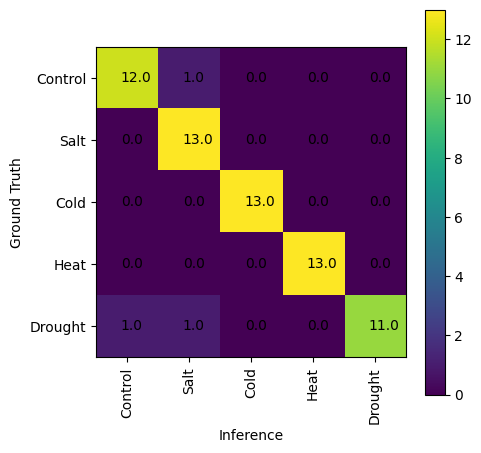


Classification Report:

              precision    recall  f1-score   support

     Control       0.92      0.92      0.92        13
        Salt       0.87      1.00      0.93        13
        Cold       1.00      1.00      1.00        13
        Heat       1.00      1.00      1.00        13
     Drought       1.00      0.85      0.92        13

    accuracy                           0.95        65
   macro avg       0.96      0.95      0.95        65
weighted avg       0.96      0.95      0.95        65



========== Infer with model_5.pth parameters ==========

Min-Max scaling of input data is in progress..

Confusion Matrix:



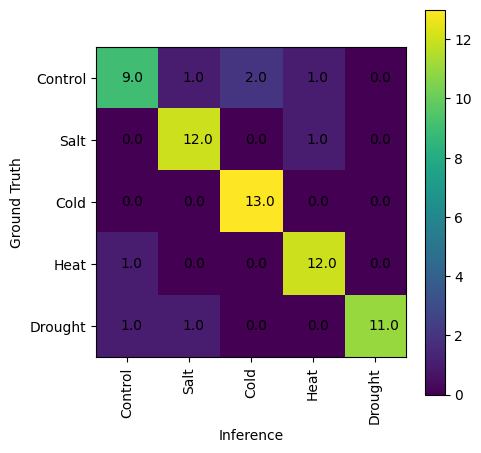


Classification Report:

              precision    recall  f1-score   support

     Control       0.82      0.69      0.75        13
        Salt       0.86      0.92      0.89        13
        Cold       0.87      1.00      0.93        13
        Heat       0.86      0.92      0.89        13
     Drought       1.00      0.85      0.92        13

    accuracy                           0.88        65
   macro avg       0.88      0.88      0.87        65
weighted avg       0.88      0.88      0.87        65



In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_dim = len(all_unique_degs)
label_dic = {0: 'Control', 1: 'Salt', 2: 'Cold', 3: 'Heat', 4: 'Drought'}
chk_point_list = [f for f in os.listdir('./Trained_models') if f[-4:]==".pth"]
chk_point_list.sort()

All_confusion = np.zeros((5, 5))

for chk_point in chk_point_list:
    print(f"\n\n========== Infer with {chk_point} parameters ==========")
    #WSI_validation
    chk_point_file = f"Trained_models/{chk_point}"
    early_stopper = EarlyStopping(patience=0, save_path=chk_point_file, norm_min_max_dic=min_max_dic, cuda_vis_dev=0)  # The save path should be modified.

    transcriptome_model = mlp_model(dim1=input_dim, label_dim=5)
    # transcriptome_model.eval()
    
    test_model, min_max_dic = early_stopper.load(transcriptome_model)
    testing_data_log2_min_max,_ = min_max_norm_TPM(testing_tpm, min_max_dic)
    
    x_data = torch.FloatTensor(testing_data_log2_min_max.values.T)
    y_data = torch.LongTensor(testing_label)

    test_output, test_loss = Inference(test_model, x_data, y_data)
    test_accuracy = Accuracy(test_output, y_data)
    
    print("Confusion Matrix:\n")
    All_confusion = All_confusion + test_accuracy[0]
    plot_confusion(test_accuracy[0], label_dic)
    print("\nClassification Report:\n")
    print(test_accuracy[1])    

# <font color="yellow">Model performance test with multiple-stress data</font>

In [29]:
multi_stress_df = pd.read_csv("Data/Ath_multi_stress_genes_TPM_filtered2.csv", index_col=0)
multi_stress_df_markers = multi_stress_df.loc[all_unique_degs]
multi_stress_df_markers
# print(multi_stress_df_ids)

,SRR11214537,SRR11214538,SRR11468696,SRR11468697,SRR11468698,SRR11468708,SRR11468709,SRR11468710,SRR11468717,SRR11468718,...,SRR23615383,SRR23615387,SRR23615388,SRR23615389,SRR23615393,SRR23615394,SRR23615395,SRR23615414,SRR23615415,SRR23615418
Gene_ID,,,,,,,,,,,,,,,,,,,,,
AT1G24600.1,20,16,16,16,11,12,9,11,8,8,...,2,26,1,19,208,71,81,4,0,1
AT5G49500.1,4,4,2,2,2,2,2,2,1,1,...,2,4,3,5,3,4,3,1,1,1
AT5G25240.1,5,6,19,18,17,28,35,34,11,10,...,2,11,3,11,21,18,29,9,5,1
AT2G41100.1,28,72,262,222,318,427,418,385,430,416,...,47,47,18,13,77,103,20,17,9,22
AT1G07985.1,7,8,21,20,11,8,14,12,6,5,...,0,13,0,16,364,192,159,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AT2G04450.1,0,1,0,0,0,1,0,0,0,0,...,2,3,1,0,1,1,0,6,4,4
AT1G65800.1,50,51,13,12,18,13,10,9,6,6,...,25,43,44,37,11,17,23,12,10,10
AT1G66390.1,0,0,0,0,1,0,0,0,0,0,...,0,7,0,4,12,13,9,1,3,0


In [30]:
multi_stress_df_label = pd.read_csv("Data/Ath_multi_stress_genes_TPM_label_filtered2-all.csv", index_col=0)
multi_stress_df_ids = multi_stress_df_markers.columns.values
multi_stress_label_dic = multi_stress_df_label.to_dict()['stress']
multi_stress_label_dic

{'SRR23615393': 'heat + drought',
 'SRR23615394': 'heat + drought',
 'SRR23615395': 'heat + drought',
 'SRR11214535': 'salt + heat',
 'SRR11214536': 'salt + heat',
 'SRR11214537': 'salt + heat',
 'SRR11214538': 'salt + heat',
 'SRR11214539': 'salt + heat',
 'SRR11468708': 'salt + heat',
 'SRR11468709': 'salt + heat',
 'SRR11468710': 'salt + heat',
 'SRR2302917': 'salt + heat',
 'SRR2302918': 'salt + heat',
 'SRR2302919': 'salt + heat'}

In [31]:
import seaborn as sns

In [32]:
def Inference_for_softmax(model,data):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # softmax = nn.Softmax(dim=1)

    with torch.no_grad():  
        model.eval()
        x = data.float().to(device)
        logit = model(x)
        output = torch.sigmoid(logit)
        return output



========== Infer with model_1.pth parameters ==========

Min-Max scaling of input data is in progress..

         SRA_ID Control  Salt Cold  Heat Drought          Stress
0   SRR11214537     0.0  16.0  0.0   2.4     0.0     salt + heat
1   SRR11214538     0.0  11.7  0.0   0.8     0.0     salt + heat
2   SRR11468708     0.2   6.6  0.0  22.4     0.0     salt + heat
3   SRR11468709     0.2   7.1  0.0  22.2     0.0     salt + heat
4   SRR11468710     0.0  12.4  0.0  21.8     0.0     salt + heat
5    SRR2302917     0.0  15.7  0.0   0.9     0.0     salt + heat
6    SRR2302918     0.0  12.4  0.0   1.7     0.0     salt + heat
7    SRR2302919     0.0  17.3  0.0   3.7     0.0     salt + heat
8   SRR23615393     0.0   0.6  0.0   0.0    23.0  heat + drought
9   SRR23615394     0.0   1.2  0.0   0.0    22.9  heat + drought
10  SRR23615395     0.0   3.1  0.0   0.0    23.0  heat + drought




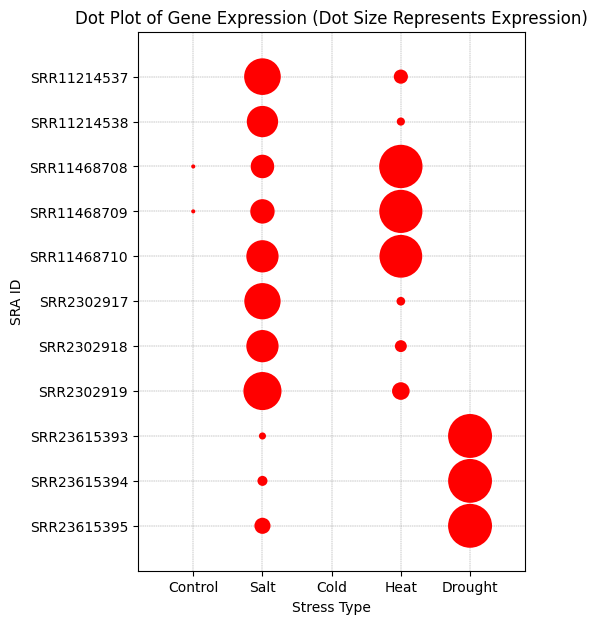



========== Infer with model_2.pth parameters ==========

Min-Max scaling of input data is in progress..

         SRA_ID Control  Salt Cold  Heat Drought          Stress
0   SRR11214537     0.0  14.1  0.0   8.5     0.0     salt + heat
1   SRR11214538     0.0   7.6  0.0   2.7     0.0     salt + heat
2   SRR11468708     0.0   3.1  0.0  22.7     0.0     salt + heat
3   SRR11468709     0.1   4.5  0.0  20.6     0.0     salt + heat
4   SRR11468710     0.0   9.4  0.0  15.1     0.0     salt + heat
5    SRR2302917     0.0  22.7  0.0   0.4     0.0     salt + heat
6    SRR2302918     0.0  12.0  0.0   4.0     0.0     salt + heat
7    SRR2302919     0.0  20.5  0.0   1.3     0.0     salt + heat
8   SRR23615393     0.0   0.0  0.0   0.0    23.1  heat + drought
9   SRR23615394     0.0   0.1  0.0   0.0    22.9  heat + drought
10  SRR23615395     0.0   0.1  0.0   0.0    23.1  heat + drought




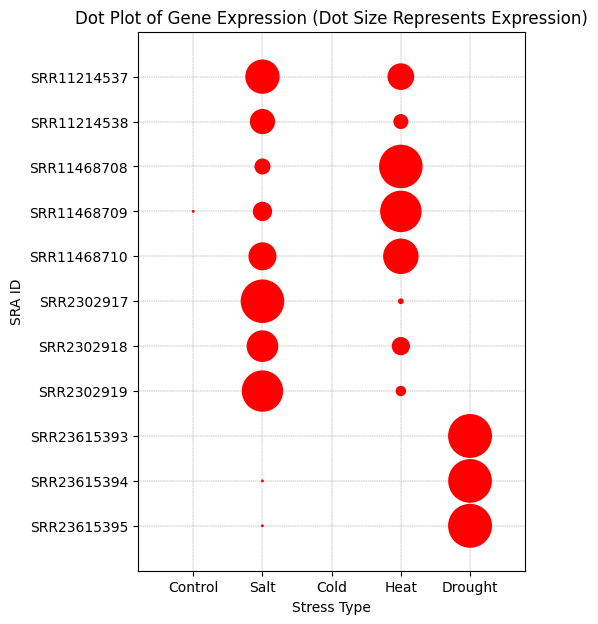



========== Infer with model_3.pth parameters ==========

Min-Max scaling of input data is in progress..

         SRA_ID Control  Salt Cold  Heat Drought          Stress
0   SRR11214537     0.0   8.6  0.0  11.3     0.1     salt + heat
1   SRR11214538     0.1   5.0  0.0   6.7     0.0     salt + heat
2   SRR11468708     0.7   1.3  0.0  21.7     0.0     salt + heat
3   SRR11468709     0.6   1.3  0.0  21.3     0.0     salt + heat
4   SRR11468710     0.3   3.8  0.0  17.7     0.0     salt + heat
5    SRR2302917     0.0  22.3  0.0   0.6     0.0     salt + heat
6    SRR2302918     0.1  11.3  0.0   4.6     0.0     salt + heat
7    SRR2302919     0.0  18.8  0.0   2.4     0.0     salt + heat
8   SRR23615393     0.0   0.0  0.0   0.0    23.1  heat + drought
9   SRR23615394     0.0   0.1  0.0   0.0    23.1  heat + drought
10  SRR23615395     0.0   0.2  0.0   0.0    23.1  heat + drought




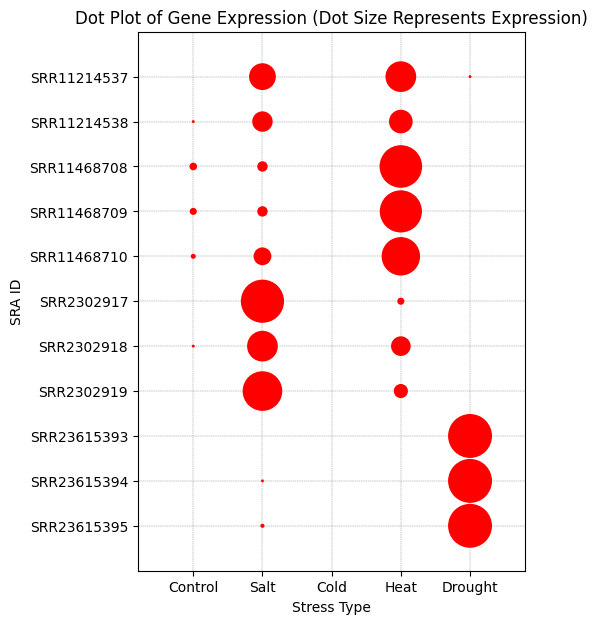



========== Infer with model_4.pth parameters ==========

Min-Max scaling of input data is in progress..

         SRA_ID Control  Salt Cold  Heat Drought          Stress
0   SRR11214537     0.0  20.2  0.0   4.3     0.0     salt + heat
1   SRR11214538     0.0  19.0  0.0   2.2     0.0     salt + heat
2   SRR11468708     0.2  10.3  0.0  21.2     0.0     salt + heat
3   SRR11468709     0.1  16.9  0.0  18.8     0.0     salt + heat
4   SRR11468710     0.1  17.4  0.0  15.4     0.0     salt + heat
5    SRR2302917     0.0  21.9  0.0   0.9     0.0     salt + heat
6    SRR2302918     0.0  16.6  0.0   4.3     0.0     salt + heat
7    SRR2302919     0.0  19.3  0.0   3.9     0.0     salt + heat
8   SRR23615393     0.0   0.0  0.0   0.0    23.1  heat + drought
9   SRR23615394     0.0   0.1  0.0   0.0    23.0  heat + drought
10  SRR23615395     0.0   0.2  0.0   0.0    23.1  heat + drought




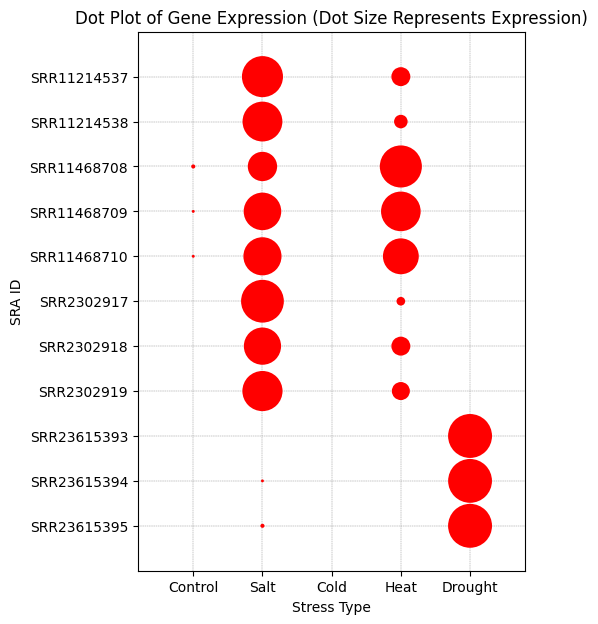



========== Infer with model_5.pth parameters ==========

Min-Max scaling of input data is in progress..

         SRA_ID Control  Salt Cold  Heat Drought          Stress
0   SRR11214537     0.0   7.9  0.0  13.8     0.1     salt + heat
1   SRR11214538     0.1   5.6  0.0   9.1     0.0     salt + heat
2   SRR11468708     0.5   3.4  0.0  22.0     0.0     salt + heat
3   SRR11468709     0.3   6.6  0.0  21.6     0.0     salt + heat
4   SRR11468710     0.1   6.7  0.0  20.6     0.0     salt + heat
5    SRR2302917     0.0  18.2  0.0   3.5     0.1     salt + heat
6    SRR2302918     0.1   5.9  0.0  14.9     0.0     salt + heat
7    SRR2302919     0.0   5.3  0.0  15.1     0.0     salt + heat
8   SRR23615393     0.0   0.0  0.0   0.0    23.1  heat + drought
9   SRR23615394     0.0   0.1  0.0   0.0    23.1  heat + drought
10  SRR23615395     0.0   0.2  0.0   0.0    23.1  heat + drought




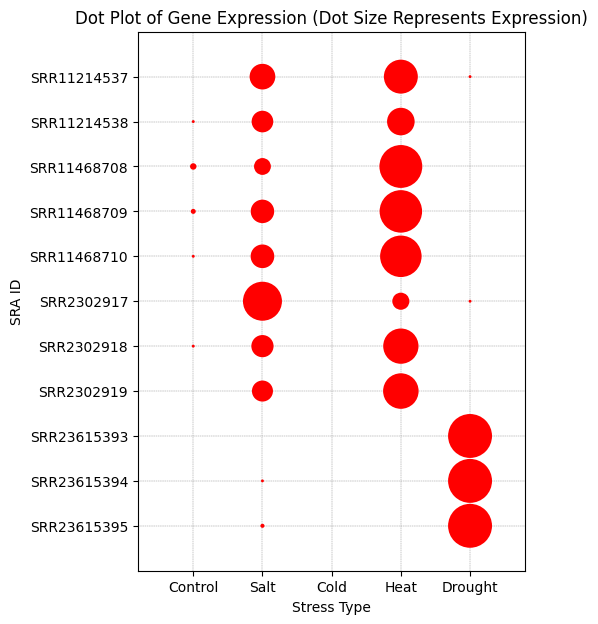

In [33]:
init = 0

for chk_point in chk_point_list:
    print(f"\n\n========== Infer with {chk_point} parameters ==========")
    #WSI_validation
    chk_point_file = f"Trained_models/{chk_point}"
    # split=chk_point.split("_")[1].split(".")[0]
    # print(split)
    early_stopper = EarlyStopping(patience=0, save_path=chk_point_file, norm_min_max_dic=min_max_dic, cuda_vis_dev=0)  # The save path should be modified.
    transcriptome_model = mlp_model(dim1=input_dim, label_dim=5)
    # transcriptome_model.eval()
    
    test_model, min_max_dic = early_stopper.load(transcriptome_model)
    testing_data_log2_min_max, _ = min_max_norm_TPM(multi_stress_df_markers, min_max_dic)
    
    x_data = torch.FloatTensor(testing_data_log2_min_max.values.T)
    y_hat = Inference_for_softmax(test_model, x_data).tolist()
    y_hat = np.array(y_hat) - 0.5

    label_columns=[]
    column_info=["SRA_ID"]
    for i in range(5):
        label_columns.append(label_dic[i])
        column_info.append(label_dic[i])
    column_info.append("Stress")

    data_frame=[]
    for index, data in enumerate(y_hat):
        rounded_data = [round(float(num)*100,1) for num in data]
        if multi_stress_df_ids[index] in multi_stress_label_dic:
            cont = [multi_stress_df_ids[index]] + rounded_data + [multi_stress_label_dic[multi_stress_df_ids[index]]]
            data_frame.append(cont)

    inference_df = pd.DataFrame(data=np.array(data_frame), columns=column_info)
    
    print(inference_df) 

    inference_df_for_graph=inference_df.drop("Stress", axis=1)
    df_long = pd.melt(inference_df_for_graph, id_vars='SRA_ID', var_name='Sample', value_name='Expression')#.sort_values('Expression')
    df_long=df_long.astype({'Expression':'float'})
    print()
    print()

    if init==0:
        sum_df = df_long
        init = 1
    else:
        sum_df['Expression']=sum_df['Expression']+df_long['Expression']
    
    plt.figure(figsize=(5, 7))
    sns.scatterplot(data=df_long, 
                    x='Sample', 
                    y='SRA_ID', 
                    size='Expression', 
                    color="red",
                    # hue='Expression', 
                    sizes=(0, 1000),  # adjust min and max dot sizes as needed
                    legend=False,
                    alpha=1, 
                    edgecolor="white",
                   )
    
    plt.title('Dot Plot of Gene Expression (Dot Size Represents Expression)')
    # plt.legend(bbox_to_anchor=(1.05, 1), title="Expression Level")
    plt.xlabel('Stress Type')
    plt.ylabel('SRA ID')
    plt.margins(x=0.2, y=0.1)
    
    plt.grid(color="grey", linestyle="--", linewidth=0.3)
    # plt.tight_layout()
    plt.gca().set_axisbelow(True)
    plt.show()    



====Average of the five-cross validation====




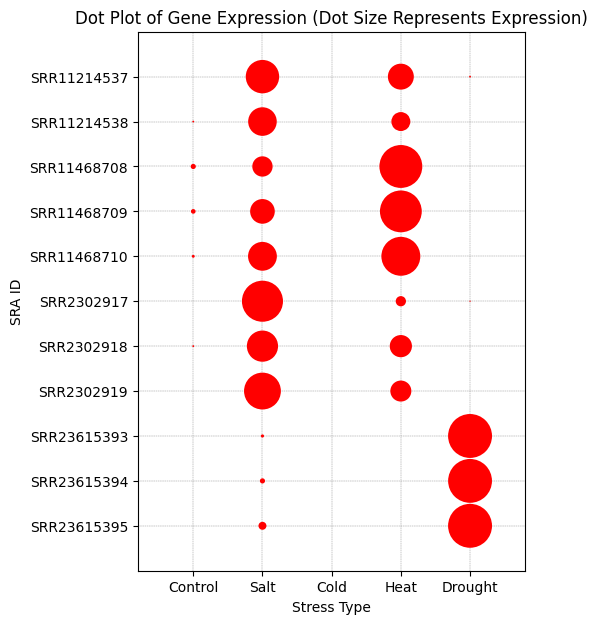

In [34]:
##_average of multi-stress prediction___
print("\n\n====Average of the five-cross validation====\n\n")
sum_df['Expression']=sum_df['Expression']/5
sum_df


plt.figure(figsize=(5, 7))
# cmap=sns.cubehelix_palette(rot=-0.2, as_cmap=True)
sns.scatterplot(data=sum_df, 
                x='Sample', 
                y='SRA_ID', 
                size='Expression', 
                color="red",
                # hue='Expression', 
                sizes=(0, 1000),  # adjust min and max dot sizes as needed
                legend=False,
                alpha=1, 
                edgecolor="white",
               )

plt.title('Dot Plot of Gene Expression (Dot Size Represents Expression)')
# plt.legend(bbox_to_anchor=(1.05, 1), title="Expression Level")
plt.xlabel('Stress Type')
plt.ylabel('SRA ID')
plt.margins(x=0.2, y=0.1)

plt.grid(color="grey", linestyle="--", linewidth=0.3)
# plt.tight_layout()
plt.gca().set_axisbelow(True)
plt.show()  